<a href="https://colab.research.google.com/github/minhyoung0724/great-ecg/blob/main/MinhyoungNa_VAE_Poisoning_Update_022421.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder (VAE) for the Electrocardiogram (ECG) Generation

# Libraries

In [1]:
pip install wfdb

     |████████████████████████████████| 133kB 16.4MB/s 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm
import datetime

import wfdb

import torch
import torch.nn as nn
from torch.utils.data import  TensorDataset, DataLoader

In [3]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size']   = 12
axisFontSize  = 14
titleFontSize = 20

# Parameters

In [4]:
dataName   = 'afdb'
resultPath = './result'
dataPath   = './data'
dataLen    = 200

data_using = 10000

In [5]:
if dataName not in dict(wfdb.get_dbs()).keys():
    for i in range(100):
        print('[ERROR] Invalid data name!!')

Make the folder

In [6]:
def makeFolder(path, folderName):
    folders = path.split('/')
    path    = folders[0]
    for folder in folders[1:]:
        path += '/' + folder
        if not os.path.isdir(path):
            os.mkdir(path)
    
    folder = path + '/' + folderName
    if not os.path.isdir(folder):
        os.mkdir(folder)
    return folder

resultFolder = makeFolder(resultPath, datetime.datetime.now().strftime("%y%m%d_%H%M%S"))
dataFolder   = makeFolder(dataPath,   dataName)

# Read the data

Download the data

In [7]:
print('Data name: {}'.format(dict(wfdb.get_dbs())[dataName]))
wfdb.dl_database(dataName, dataFolder)

Data name: MIT-BIH Atrial Fibrillation Database
Generating record list for: 00735
Generating record list for: 03665
Generating record list for: 04015
Generating record list for: 04043
Generating record list for: 04048
Generating record list for: 04126
Generating record list for: 04746
Generating record list for: 04908
Generating record list for: 04936
Generating record list for: 05091
Generating record list for: 05121
Generating record list for: 05261
Generating record list for: 06426
Generating record list for: 06453
Generating record list for: 06995
Generating record list for: 07162
Generating record list for: 07859
Generating record list for: 07879
Generating record list for: 07910
Generating record list for: 08215
Generating record list for: 08219
Generating record list for: 08378
Generating record list for: 08405
Generating record list for: 08434
Generating record list for: 08455
Generating list of all files for: 00735
Generating list of all files for: 03665
Generating list of all

Read the data

In [8]:
data = []
labels = []
classes = []

halfLen = dataLen // 2
label = 0

for fileName in wfdb.io.get_record_list(dataName):
    try:
        # Get the signal
        ECG   = wfdb.rdsamp(os.path.join(dataFolder, fileName))[0]
        peaks = wfdb.rdann(os.path.join(dataFolder, fileName), 'qrs').sample

        classes.append(fileName)
        
        # Parsing the data
        ECGlen = ECG.shape[0]
        print('Read: File [{}]'.format(fileName));

        for peak in peaks:
            if 0 <= peak-halfLen and peak+halfLen <= ECGlen:
              data.append(ECG[peak-halfLen:peak+halfLen, 0])
              data.append(ECG[peak-halfLen:peak+halfLen, 1])
              labels.append(label)
              labels.append(label)

        label += 1

    except Exception as e:
        print('Exception: File [{}] ({})'.format(fileName, e))
        
data = np.array(data)
data = data.astype(np.float32)
print(data)
print(data.shape)

classes = np.array(classes)
print(classes)
print(classes.shape)

labels = np.array(labels)
print(labels)
print(labels.shape)

Exception: File [00735] (sampto must be greater than sampfrom)
Exception: File [03665] (sampto must be greater than sampfrom)
Read: File [04015]
Read: File [04043]
Read: File [04048]
Read: File [04126]
Read: File [04746]
Read: File [04908]
Read: File [04936]
Read: File [05091]
Read: File [05121]
Read: File [05261]
Read: File [06426]
Read: File [06453]
Read: File [06995]
Read: File [07162]
Read: File [07859]
Read: File [07879]
Read: File [07910]
Read: File [08215]
Read: File [08219]
Read: File [08378]
Read: File [08405]
Read: File [08434]
Read: File [08455]
[[-0.61  -0.61  -0.645 ... -0.17  -0.19  -0.18 ]
 [-0.28  -0.29  -0.275 ... -0.225 -0.215 -0.23 ]
 [-0.615 -0.56  -0.5   ...  0.05   0.025  0.02 ]
 ...
 [ 0.24   0.255  0.14  ...  0.06   0.035  0.15 ]
 [-0.655  0.16  -0.905 ...  1.075 -0.295 -0.405]
 [-0.02   0.025  0.22  ...  0.265  0.43   0.375]]
(2257110, 200)
['04015' '04043' '04048' '04126' '04746' '04908' '04936' '05091' '05121'
 '05261' '06426' '06453' '06995' '07162' '07859' 

Normalize the data (data $\in \left[0, 1\right]$)

In [9]:
data = (data - data.min()) / (data.max() - data.min())

Shuffle the data

In [10]:
idx = np.arange(data.shape[0])
np.random.shuffle(idx)

data = data[idx]
print ("data: ", data)
labels = labels[idx]
print ("labels: ", label)

data:  [[0.47321162 0.4750075  0.47680336 ... 0.4797965  0.4797965  0.47829992]
 [0.46303502 0.4612392  0.4621371  ... 0.47111645 0.4827896  0.5028435 ]
 [0.51032627 0.50823104 0.5064352  ... 0.4702185  0.4696199  0.47081715]
 ...
 [0.48877582 0.48847649 0.48877582 ... 0.49146962 0.4926669  0.49236757]
 [0.47889853 0.47919786 0.47859925 ... 0.47171506 0.47351095 0.47261298]
 [0.45645016 0.45585155 0.4573481  ... 0.47410956 0.47321162 0.47440886]]
labels:  23


#Finding QRS and Non-QRS

In [11]:
QRS_WIDTH = 50
NON_QRS_WIDTH = 50

data_valid = np.zeros((0, 200))
labels_valid = []
data_qrs = np.zeros((0, 50))
data_non_qrs = np.zeros((0, 50))

cnt = -1
for item in data[:data_using]:
  cnt += 1
  peak = np.argmax(item)
  if peak < QRS_WIDTH or peak > dataLen-QRS_WIDTH or peak < QRS_WIDTH/2 + NON_QRS_WIDTH or peak > dataLen - (QRS_WIDTH/2 + NON_QRS_WIDTH):  #invailed data
    continue
  data_qrs = np.vstack([data_qrs, item[peak-(QRS_WIDTH//2):peak+(QRS_WIDTH//2)]])
  data_non_qrs = np.vstack([data_non_qrs, item[peak-QRS_WIDTH//2-NON_QRS_WIDTH:peak-QRS_WIDTH//2]])
  data_valid = np.vstack([data_valid, item])
  labels_valid.append(labels[cnt])

data_non_qrs = data_non_qrs.astype(np.float32)
data_qrs = data_qrs.astype(np.float32)

#Designing VAE to make fake non-QRS data 

In [12]:
class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()
    
    Z_DIM = 5

    # encoder part
    self.fc1 = nn.Linear(50, 40)
    self.fc2 = nn.Linear(40, 40)
    self.fc3 = nn.Linear(40, 30)
    self.fc4 = nn.Linear(30, 30)
    self.fc5_m = nn.Linear(30, Z_DIM)
    self.fc5_l = nn.Linear(30, Z_DIM)

    # decoder part
    self.fc6 = nn.Linear(Z_DIM, 30)
    self.fc7 = nn.Linear(30, 30)
    self.fc8 = nn.Linear(30, 40)
    self.fc9 = nn.Linear(40, 40)
    self.fc10 = nn.Linear(40, 50)

  def encoder(self, x):
    h = nn.functional.relu(self.fc1(x))
    h = nn.functional.relu(self.fc2(h))
    h = nn.functional.relu(self.fc3(h))
    h = nn.functional.relu(self.fc4(h))
    return self.fc5_m(h), self.fc5_l(h) # mu, log_var

  def sampling(self, mu, log_var):
    std = torch.exp(0.5*log_var)
    eps = torch.randn_like(std)
    return eps.mul(std).add_(mu) # return z sample

  def decoder(self, z):
    h = nn.functional.relu(self.fc6(z))
    h = nn.functional.relu(self.fc7(h))
    h = nn.functional.relu(self.fc8(h))
    h = nn.functional.relu(self.fc9(h))
    return torch.sigmoid(self.fc10(h))

  def forward(self, x):
      mu, log_var = self.encoder(x.view(-1, 50))
      z = self.sampling(mu, log_var)
      return self.decoder(z), mu, log_var

In [13]:
train_data = torch.tensor(data_non_qrs[:data_non_qrs.shape[0] - 50])
train_label= torch.tensor(data_non_qrs[:data_non_qrs.shape[0] - 50])
train_dataset = TensorDataset(train_data, train_label)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

test_data = torch.tensor(data_non_qrs[data_non_qrs.shape[0] - 50:])
test_label = torch.tensor(data_non_qrs[data_non_qrs.shape[0] - 50:])
test_dataset = TensorDataset(test_data, test_label)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [14]:
vae = VAE()

if torch.cuda.is_available():
    vae.cuda()

optimizer = torch.optim.Adam(vae.parameters(), lr=0.005)
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    func = torch.nn.BCELoss(size_average=False);
    #BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 50), reduction='sum')
    BCE = func(recon_x, x)
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE

In [15]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [16]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [17]:
for epoch in range(0, 10):
    train(epoch)
    test()

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 0 [0/6531 (0%)]	Loss: 34.713379
Train Epoch: 0 [400/6531 (6%)]	Loss: 34.656479
Train Epoch: 0 [800/6531 (12%)]	Loss: 34.635883
Train Epoch: 0 [1200/6531 (18%)]	Loss: 34.589436
Train Epoch: 0 [1600/6531 (24%)]	Loss: 34.600140
Train Epoch: 0 [2000/6531 (31%)]	Loss: 34.629093
Train Epoch: 0 [2400/6531 (37%)]	Loss: 34.659786
Train Epoch: 0 [2800/6531 (43%)]	Loss: 34.640736
Train Epoch: 0 [3200/6531 (49%)]	Loss: 34.624584
Train Epoch: 0 [3600/6531 (55%)]	Loss: 34.598587
Train Epoch: 0 [4000/6531 (61%)]	Loss: 34.615494
Train Epoch: 0 [4400/6531 (67%)]	Loss: 34.567738
Train Epoch: 0 [4800/6531 (73%)]	Loss: 34.645031
Train Epoch: 0 [5200/6531 (80%)]	Loss: 34.660206
Train Epoch: 0 [5600/6531 (86%)]	Loss: 34.655067
Train Epoch: 0 [6000/6531 (92%)]	Loss: 34.607735
Train Epoch: 0 [6400/6531 (98%)]	Loss: 34.661278
====> Epoch: 0 Average loss: 34.6236
====> Test set loss: 34.6212
Train Epoch: 1 [0/6531 (0%)]	Loss: 34.605034
Train Epoch: 1 [400/6531 (6%)]	Loss: 34.613876
Train Epoch: 1 [

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


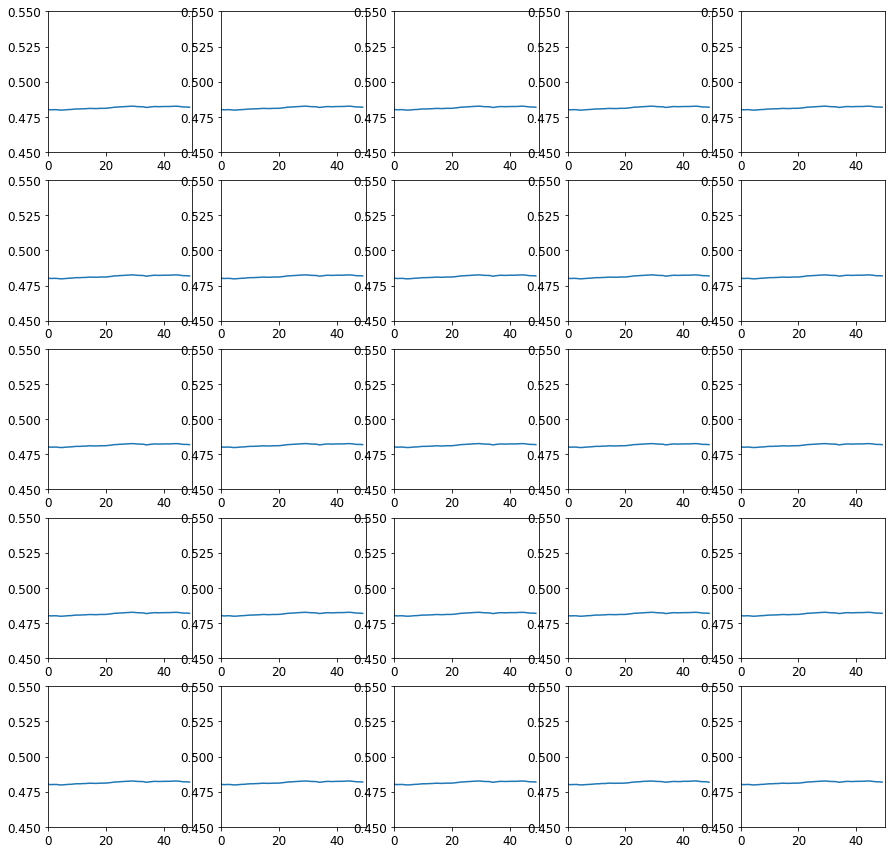

In [18]:
FAKE_SIZE = 1000

sample = np.zeros((0, 50))

with torch.no_grad():
  for i in range(FAKE_SIZE):
    z = torch.randn(64, 5).cuda()
    sample = np.vstack([sample, vae.decoder(z).cuda().cpu().numpy()])


plt.figure(figsize=(15, 15))

for i in range(1, 26):
   plt.subplot(5, 5, i)
   plt.plot(sample[i-1].T)

   plt.xlim(0, QRS_WIDTH-1)
   plt.axis([0, 50, 0.45, 0.55])
plt.show()


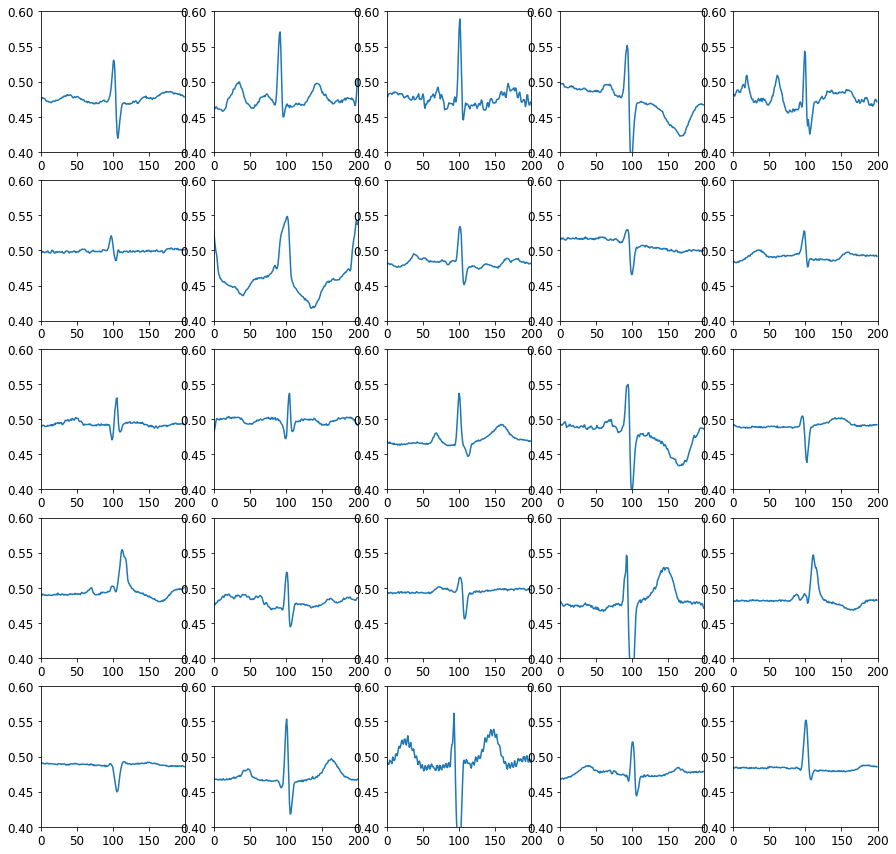

In [20]:
plt.figure(figsize=(15, 15))

for i in range(1, 26):
  plt.subplot(5, 5, i)
  plt.plot(data_valid[i-1].T)

  plt.xlim(0, QRS_WIDTH-1)
  plt.axis([0, 200, 0.4, 0.6])
plt.show()


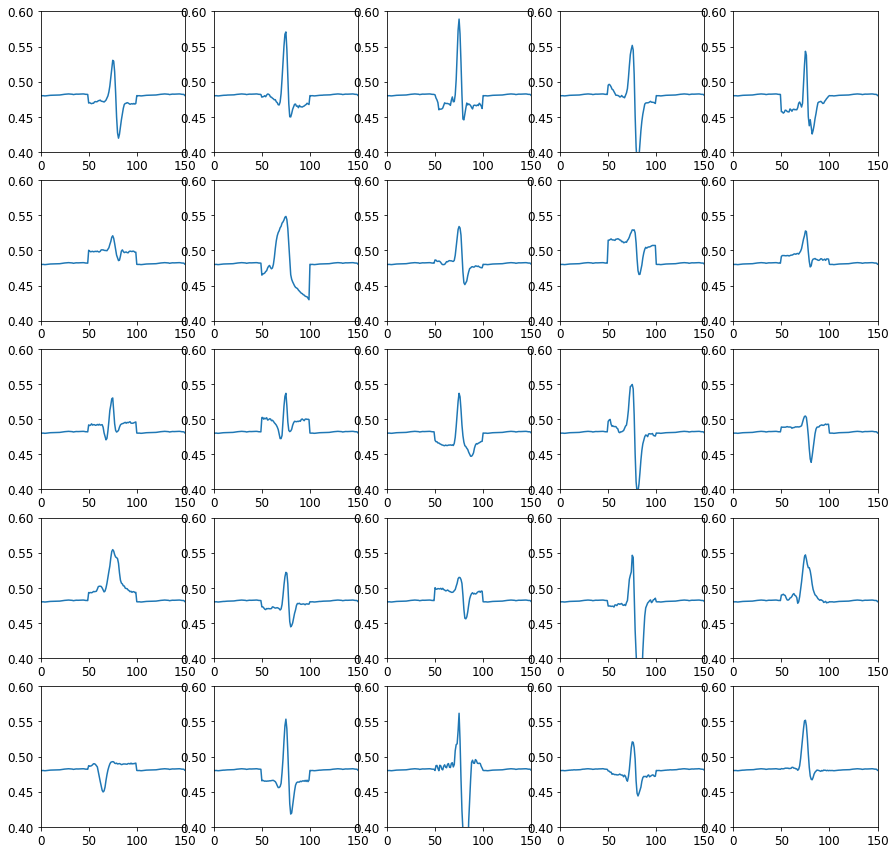

In [21]:
result = np.zeros((0, 200))
for i in range(FAKE_SIZE):
  tmp = np.hstack([sample[i], data_qrs[i]])
  tmp = np.hstack([tmp, sample[i]])
  tmp = np.hstack([tmp, sample[i]])
  result = np.vstack([result, tmp])


plt.figure(figsize=(15, 15))

for i in range(1, 26):
  plt.subplot(5, 5, i)
  plt.plot(result[i-1].T)

  plt.xlim(0, 200)
  plt.axis([0, 150, 0.4, 0.6])
plt.show()


In [22]:
np.save("./poisoned_data", result)
np.save("./poisoned_label", labels_valid[:FAKE_SIZE])

In [23]:
data_load = np.load("./poisoned_data.npy")
label_load = np.load("./poisoned_label.npy")

In [24]:
print(data_load)
print(label_load)

[[0.48020527 0.4800081  0.48011029 ... 0.48198402 0.48200324 0.48183584]
 [0.48019725 0.4800027  0.48009425 ... 0.48200452 0.48201239 0.48181096]
 [0.48020527 0.4800081  0.48011029 ... 0.48198402 0.48200324 0.48183584]
 ...
 [0.48020527 0.4800081  0.48011029 ... 0.48198402 0.48200324 0.48183584]
 [0.48020527 0.4800081  0.48011029 ... 0.48198402 0.48200324 0.48183584]
 [0.48020527 0.4800081  0.48011029 ... 0.48198402 0.48200324 0.48183584]]
[18 22  9  0  5 15  2 18  3 15 12 12  2  0 17  2 18  3 20  2 16 12 20 18
 16  7  9 22 18 18 15  3 15  4 15 20 12  1  2  6 17  0  3  0  1 17 18 15
  1  0 17  5  5 21  2 21 22  8  4  0 13  9  0  1  3  3  1  9 15 17 14 18
  2  3  6 12  8  6 15 15 12  4 16 21  5 21 15 21 14  4  8  8  1  6 22  3
  8  7  1 16  9 15 14  4  4  6  9 20  3 16  1  8 17  9  0 15 17  0 12 12
  8  7 21  4  3  6 16 18  1 21  7 20 17 14  9  0 14 21  0 18  7 14 12  6
  8 16  6  3  5 18  2 18  8  0  9 22 16  8  0  8 18  8 15 15  9  4 18 14
  9  4 14 20  2 19  2 16 15  9  0  3 14 15 21

In [26]:
poison_x = torch.tensor(data_load)
poison_label = torch.tensor(labels_valid[:FAKE_SIZE])
poison_dataset = TensorDataset(poison_x, poison_label)
poison_loader = DataLoader(poison_dataset, batch_size=64, shuffle=True)